In [180]:
#!pip install catboost
#!pip install xgboost
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import date
import requests
from itertools import combinations
from scipy.stats import pearsonr, chi2_contingency
from scipy.stats import poisson
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from time import time
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMClassifier
import seaborn as sns
sns.set()

In [674]:
#load data taken from sportsdatabase.com's SDQL
nbastats = pd.read_csv('../nba_over_under/nba_data/nba_stats_05-19.csv')

In [675]:
nbastats.shape

(38240, 63)

In [676]:
#Change the Supersonics to their current name Thunder so theres not two names
nbastats.loc[nbastats['team'] == 'Supersonics', 'team'] = 'Thunder'
nbastats.loc[nbastats['op team'] == 'Supersonics', 'op team'] = 'Thunder'

In [677]:
#make a matchup column where each matchup is the same i.e. x vs y
#nbastats['matchup'] = 0

#for row, index in zip(nbastats.values, nbastats.index):
#    matchup = row[1] + ' ' + row[3]
#    nbastats['matchup'][index] = matchup

In [678]:
#make a matchup column where each matchup is the same i.e. A vs B and none are B vs A 
nbastats['matchup'] = 0

for row, index in zip(nbastats.values, nbastats.index):
    matchup = row[1] + ' ' + row[3]
    matchups = matchup.split(' ')
    matchups.sort()
    matchupz = ' '.join(matchups)
    nbastats['matchup'][index] = matchupz

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [679]:
#Read in ELO data from 538
elo = pd.read_csv('../nba_over_under/nba_data/nbaallelo.csv')

In [680]:
#change sixers and supersonics names so they match the main df
elo.loc[elo['fran_id'] == 'Sixers', 'fran_id'] = 'Seventysixers'
elo.loc[elo['fran_id'] == 'Supersonics', 'fran_id'] = 'Thunder'

In [681]:
#match the date format to the main df
elo['date_game'] = pd.to_datetime(elo['date_game'])
elo['date_game'] = elo.date_game.dt.strftime('%Y%m%d').astype(int)

In [682]:
#adds the elo pregame stat to the main df, only 2005-2014 is available
nbastats['elo'] = 0
for index, row in nbastats.iterrows():
    if 2005 <= row['season'] <= 2014:
        a = row['date']
        b = row['team']
        c = elo.loc[(elo['date_game'] == a) & (elo['fran_id'] == b), 'elo_i']
        if c.size:
            nbastats['elo'][index] = c.values[0]
        if not c.size:
            continue
    else:
        continue

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [695]:
#make column where >=finalscore-vegasline is 1 and < is 0
nbastats['o/u'] = 0
nbastats.loc[nbastats['o/u margin'] >= 0, 'o/u'] = 1
nbastats.loc[nbastats['o/u margin'] < 0, 'o/u'] = 0

In [696]:
#column for win loss stat
nbastats['WL'] = 0
nbastats.loc[nbastats['points'] > nbastats['op points'], 'WL'] = 1
nbastats.loc[nbastats['points'] < nbastats['op points'], 'WL'] = -1

In [697]:
#convert conference to number
nbastats.loc[nbastats['conference west/east'] == 'Western', 'conference west/east'] = 1
nbastats.loc[nbastats['conference west/east'] == 'Eastern', 'conference west/east'] = 0

In [698]:
#convert home away to number
nbastats.loc[nbastats['home away'] == 'home', 'home away'] = 1
nbastats.loc[nbastats['home away'] == 'away', 'home away'] = 0

In [699]:
#make column where >=finalscore-vegasline is 1 and < is 0
    #vegas line is the over/under line given out of vegas
nbastats['o/u margin class'] = 0

#threshold to cutoff o/u margin for groups
mthresh = 10

nbastats.loc[nbastats['o/u margin'] >= mthresh, 'o/u margin class'] = 1
nbastats.loc[(nbastats['o/u margin'] < mthresh) & 
             (nbastats['o/u margin'] > -mthresh), 'o/u margin class'] = 0
nbastats.loc[nbastats['o/u margin'] <= -mthresh, 'o/u margin class'] = -1

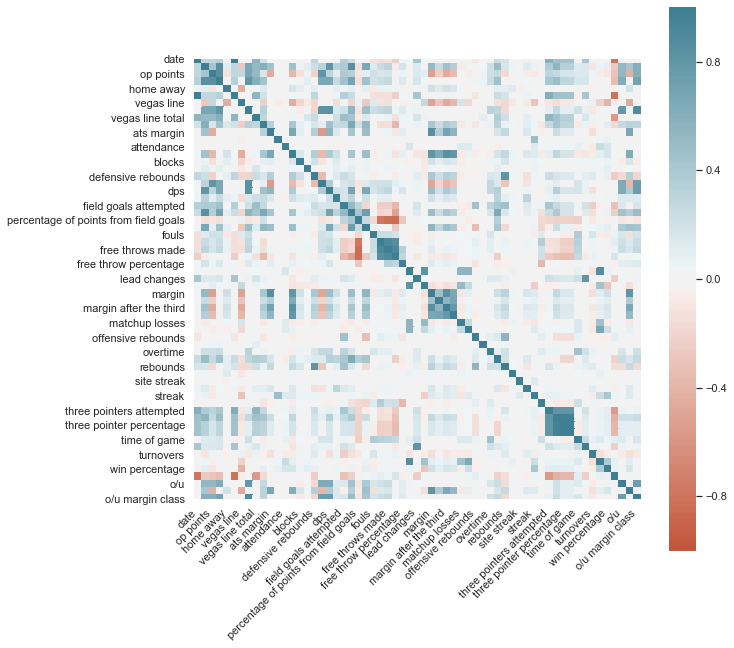

In [700]:
#Correlation Matrix
corr = nbastats.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [701]:
#onehot the timezone, division, and day columns
nbastats = pd.get_dummies(nbastats, prefix_sep="__", columns=['time zone', 'division', 'day'])

In [703]:
#percentage of nans
nan_mean = (nbastats.isna().mean() * 100).round(3)
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean

margin after the first                      0.010
overtime                                    0.010
margin at the half                          0.010
margin after the third                      0.010
percentage of points from three pointers    0.026
three pointer percentage                    0.026
three pointers made                         0.026
three pointers attempted                    0.026
steals                                      0.026
rebounds                                    0.026
officials                                   0.026
offensive rebounds                          0.026
free throw percentage                       0.026
assists                                     0.026
free throws made                            0.026
blocks                                      0.026
defensive rebounds                          0.026
percentage of points from free throws       0.026
field goals made                            0.026
percentage of points from field goals       0.026


In [704]:
#fill numerical nans with mean from whole data set, hopefully not too much leakage since % is small
    #should use means from each season to avoid leakage into test
fill_mean = nan_mean.index.values
nbastats[fill_mean] = nbastats[fill_mean].fillna(nbastats[fill_mean].mean())

In [705]:
#fill categorical nans with ['NA']
nbastats['officials'] = nbastats['officials'].fillna('NA')

In [706]:
#remaining categorical columns
cat_feat = nbastats.select_dtypes('object').columns.values
nbastats[cat_feat].nunique().sort_values()

time zone        4
division         6
day              7
team            30
op team         30
matchup        435
officials    15038
dtype: int64

In [707]:
#pearson correlation filter
def highcorrelation(df, thresh):
    num_feat = df.select_dtypes('number').columns.values
    comb_num_feat = np.array(list(combinations(num_feat, 2)))
    corr_num_feat = np.array([])

    for comb in comb_num_feat:
        corr = pearsonr(df[comb[0]], df[comb[1]])[0]
        corr_num_feat = np.append(corr_num_feat, corr)
    high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= thresh]
    return high_corr_num

In [708]:
#correlated features > .8
highcorrelation(nbastats, .8)

array([['date', 'season'],
       ['points', 'total points'],
       ['points', 'dps'],
       ['points', 'field goals made'],
       ['op points', 'total points'],
       ['op points', 'dpa'],
       ['season', 'elo'],
       ['o/u margin', 'dpa'],
       ['o/u margin', 'dps'],
       ['o/u margin', 'o/u margin class'],
       ['ats margin', 'margin'],
       ['biggest lead', 'margin'],
       ['biggest lead', 'margin after the third'],
       ['defensive rebounds', 'rebounds'],
       ['percentage of points from field goals', 'free throws made'],
       ['percentage of points from field goals',
        'percentage of points from free throws'],
       ['free throws attempted', 'free throws made'],
       ['free throws attempted', 'percentage of points from free throws'],
       ['free throws made', 'percentage of points from free throws'],
       ['game number', 'losses'],
       ['game number', 'wins'],
       ['lead changes', 'times tied'],
       ['margin', 'margin after the third'

In [709]:
#drop highly correlated values
nbastats = nbastats.drop(['date', 'total points', 'dps', 'field goals made', 'dpa', 
                          'ats margin', 'margin', 'margin after the third', 'time zone__E', 
                          'rebounds', 'percentage of points from field goals', 'free throws attempted',
                          'percentage of points from free throws','game number', 'times tied',
                          'three pointers attempted', 'three pointer percentage',
                          'percentage of points from three pointers'], axis=1, errors='ignore')

In [710]:
nbastats.columns

Index(['team', 'points', 'op team', 'op points', 'home away', 'season',
       'vegas line', 'o/u margin', 'vegas line total', 'assists', 'ats streak',
       'attendance', 'biggest lead', 'blocks', 'conference west/east', 'day',
       'defensive rebounds', 'division', 'fast break points',
       'field goals attempted', 'field goal percentage', 'fouls',
       'free throws made', 'free throw percentage', 'lead changes', 'losses',
       'margin after the first', 'margin at the half', 'matchup losses',
       'matchup wins', 'offensive rebounds', 'officials', 'ou streak',
       'overtime', 'points in the paint', 'rest', 'site streak', 'steals',
       'streak', 'team rebounds', 'three pointers made', 'time of game',
       'time zone', 'turnovers', 'wins', 'win percentage', 'matchup', 'elo',
       'o/u', 'WL', 'o/u margin class'],
      dtype='object')

In [714]:
#ingame/postgame stats excluding o/u stats
in_game_mask = ['matchup', 'points', 'op points', 'assists', 'biggest lead', 'blocks', 
       'defensive rebounds', 'fast break points', 'field goals attempted',
       'field goal percentage', 'fouls', 'free throws made',
       'free throw percentage', 'lead changes', 'margin after the first', 'margin at the half', 
        'overtime', 'offensive rebounds', 'points in the paint', 'steals',
       'team rebounds', 'three pointers made', 'time of game',
       'turnovers', 'WL']

#mask for EMA, these features will be imputed as exponential moving average of last n games
ema_mask = ['points', 'op points', 'assists', 'biggest lead', 'blocks', 
       'defensive rebounds', 'fast break points', 'field goals attempted',
       'field goal percentage', 'fouls', 'free throws made',
       'free throw percentage', 'lead changes','margin after the first', 'margin at the half', 
       'offensive rebounds', 'overtime', 'points in the paint', 'steals',
       'team rebounds', 'three pointers made', 'time of game',
       'turnovers', 'WL']

#pregame stats
ext_game_mask = ['elo', 'team', 'op team', 'home away', 'vegas line', 'vegas line total', 'ats streak',
       'attendance', 'conference west/east', 'day', 'division', 'losses', 'matchup losses',
       'matchup wins', 'ou streak', 'rest', 'site streak', 'streak', 'time zone', 'wins', 
       'win percentage', 'matchup', 'WL']

In [715]:
# Define a function which creates an EMA DataFrame from the nbastats df
def create_stats_features_ema(span):
    ema = nbastats.copy()
    #columns for ema
    feature_names = ema_mask
    # Loop over the features, group by team and impute ema
    for feature_name in feature_names:
        feature_ema = (ema.groupby('team')[feature_name] # Calculate the EMA
                                                  .transform(lambda row: round(row.ewm(span=span, 
                                                    min_periods=2).mean().shift(1), 3))) 
                                                # Shift the data down 1 so we don't leak data
        ema[feature_name] = feature_ema
    return ema

In [716]:
#new datafram with EMAs imputed
nbastats_ema = create_stats_features_ema(span=3)

In [717]:
#These columns need to be moved so that the home and away teams are on one row, the common
    #features like vegas line total stay put
away_columns = ['elo', 'team', 'points', 'home away',
       'vegas line', 'assists', 
       'biggest lead', 'blocks', 'conference west/east',
       'defensive rebounds', 'division', 'fast break points',
       'field goals attempted', 'field goal percentage', 'fouls',
       'free throws made', 'free throw percentage', 'losses',
       'margin after the first', 'margin at the half', 'matchup losses',
       'matchup wins', 'offensive rebounds', 'ou streak',
       'points in the paint', 'rest', 'site streak', 'steals',
       'streak', 'team rebounds', 'three pointers made',
       'time zone', 'turnovers', 'wins', 'win percentage',
       'WL']
home_columns = ['elo', 'team', 'points', 'home away',
       'vegas line', 'assists', 
       'biggest lead', 'blocks', 'conference west/east',
       'defensive rebounds', 'division', 'fast break points',
       'field goals attempted', 'field goal percentage', 'fouls',
       'free throws made', 'free throw percentage', 'losses',
       'margin after the first', 'margin at the half', 'matchup losses',
       'matchup wins', 'offensive rebounds', 'ou streak',
       'points in the paint', 'rest', 'site streak', 'steals',
       'streak', 'team rebounds', 'three pointers made',
       'time zone', 'turnovers', 'wins', 'win percentage',
       'WL']


In [718]:
#make home and away split df, so now there is one row with home and away stats with one output
    #instead of two rows for the same game with one output
nbastats_ema_away = nbastats_ema[1::2][away_columns]
nbastats_ema_home = nbastats_ema[::2]

nbastats_ema_away = nbastats_ema_away.reset_index(drop=True)
nbastats_ema_home = nbastats_ema_home.reset_index(drop=True)

nbastats_ema_away = (nbastats_ema_away.rename(columns={col: col + '_Away' 
                                                       for col in nbastats_ema_away.columns}))
nbastats_ema_home = (nbastats_ema_home.rename(columns={col: col + '_Home' 
                                                       for col in home_columns}))
nbastats_ema_homeaway = pd.concat([nbastats_ema_home, nbastats_ema_away], axis=1, join='inner')
nbastats_ema_homeaway = nbastats_ema_homeaway.drop(['op team', 'op points'], axis=1)

In [720]:
#make column for elo difference (difference in strengths)
nbastats_ema_homeaway['elo diff'] = abs(nbastats_ema_homeaway['elo_Home'] - 
                                        nbastats_ema_homeaway['elo_Away'])

In [721]:
#drop any nans
nbastats_ema_homeaway = nbastats_ema_homeaway.dropna()
nbastats_ema_homeaway = nbastats_ema_homeaway.reset_index(drop=True)

In [ ]:
#save the csv file to avoid having to run all the previous cells in the future
nbastats_ema_homeaway.to_csv('NBASTATS.csv', index=False, compression='gzip')

In [722]:
#begin making train, validation and test sets
X_train = nbastats_ema_homeaway.copy()
X_test = nbastats_ema_homeaway.copy()

#elo is not available in >2014 and 2005 is a bunch of nans because it is the first season
X_train_set = []
for i in range(2006, 2015):
    X_train_set.append(X_train[X_train['season'] == i])

X_test_set = []
for i in range(2006, 2015):
    X_test_set.append(X_test[X_test['season'] == i])

In [526]:
#this was tried first, imputing average stats from entire previous season

#average up ingame/postgame stats by matchup in training set to apply to test set's matchups,
    #this way we are not using data in the test that would be unknown at the time of placing an
    #actual bet pregame
#for i in range(1, len(X_train_set)):
    #get averages of previous season
#    ma = X_train_set[i-1][in_game_mask]
#    matchup_averages = ma.groupby(by='matchup', as_index=True).mean()
    #matchup_averages.reset_index(drop=True, inplace=True)
        
    #impute averages of ingame stats from training set into ingame stat columns in test set
#    for j in in_game_mask:
#        if j == 'matchup':
#            continue    
#        for index, row in X_test_set[i].iterrows():
#            a = row['matchup']
#            if a not in matchup_averages.index:
#                continue
#            X_test_set[i][j][index] = matchup_averages[j][a]

#in_game_mask.remove('matchup')

#for i in in_game_mask:
#    for index, row in X_test.iterrows():
#        X_test[i][index] = matchup_averages[matchup_averages['matchup'] == row['matchup']][i]

In [723]:
#make concatinated full train,test and get indices for each train,test for CV, leave out 2014 for 
    #final test
X_train = pd.concat(X_train_set, ignore_index=True)
X_test = pd.concat(X_test_set, ignore_index=True)

y_train = X_train['o/u']
y_test = X_test['o/u']

X_train_2012 = X_train[X_train['season']== 2012]
y_train_2012 = X_train_2012['o/u']

X_test_2013 = X_test[X_test['season'] == 2013]
y_test_2013 = X_test_2013['o/u']

#continuous target of o/u margin
y_train_cont_2012 = X_train_2012['o/u margin']
y_test_cont_2013 = X_test_2013['o/u margin']

y_train_cont = X_train['o/u margin']
y_test_cont = X_test['o/u margin']

X_train_final = X_train[X_train['season']== 2013]
y_train_final = X_train_final['o/u']

X_test_final = X_test[X_test['season'] == 2014]
y_test_final = X_test_final['o/u']
y_test_cont_final = X_test_final['o/u margin']

#2012 - train
#2013 - validation
#2014 - test
    

In [725]:
#indicies for to tell the crossvalidation how to handle the folds since the seasons are time ordered
    #2014 is held out
indices = list()
for i in range(2010, 2013):
    train = X_train.loc[X_train['season'] == i].index
    test = X_test.loc[X_test['season'] == i+1].index
    indices.append((train, test))

In [726]:
#pairplot of all features, takes too long to load
#fig, axes = plt.subplots(1,1, figsize=(10,10))
#g = sns.PairGrid(X_train_2017.sample(1000), diag_sharey=False)
#g.map_upper(sns.scatterplot, hue='o/u')
#g.map_diag(sns.kdeplot, lw=2)

KeyError: 'o/u margin'

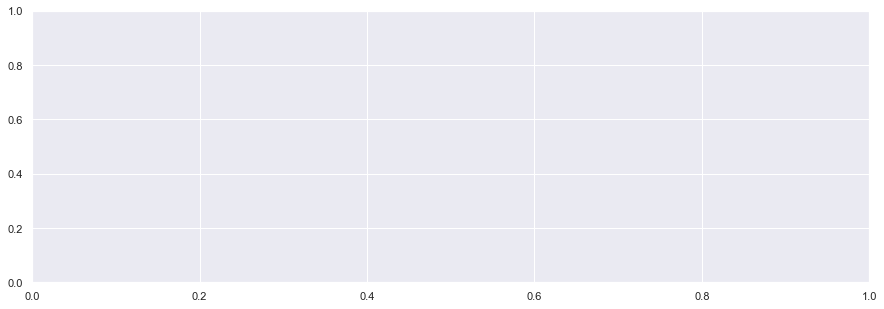

In [768]:
#boxplot of average of o/u margin for each matchup, looks like cot(x)
fig, axes = plt.subplots(1,1, figsize=(15,8))
g = sns.boxplot(x='matchup', y='o/u margin', data=X_train_2012.groupby('matchup', as_index=False).
                    mean().sort_values('o/u margin', ascending=False))
g = plt.xticks(rotation=45)

In [730]:
#check correlations one more time
highcorrelation(X_train, .8)

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


array([['vegas line_Home', 'vegas line_Away'],
       ['o/u margin', 'o/u margin class'],
       ['biggest lead_Home', 'margin at the half_Home'],
       ['matchup losses_Home', 'matchup wins_Away'],
       ['matchup wins_Home', 'matchup losses_Away'],
       ['streak_Home', 'WL_Home'],
       ['biggest lead_Away', 'margin at the half_Away'],
       ['streak_Away', 'WL_Away']], dtype='<U27')

In [731]:
highcorrelation(X_test, .8)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


array([['vegas line_Home', 'vegas line_Away'],
       ['o/u margin', 'o/u margin class'],
       ['biggest lead_Home', 'margin at the half_Home'],
       ['matchup losses_Home', 'matchup wins_Away'],
       ['matchup wins_Home', 'matchup losses_Away'],
       ['streak_Home', 'WL_Home'],
       ['biggest lead_Away', 'margin at the half_Away'],
       ['streak_Away', 'WL_Away']], dtype='<U27')

In [732]:
#drop targets and correlated features
droplist = ['o/u margin', 'o/u margin class', 'o/u', 'vegas line_Away', 'margin at the half_Home', 
           'matchup wins_Away', 'matchup losses_Away', 'streak_Home', 'margin at the half_Away', 
           'streak_Away']
X_train = X_train.drop(droplist, axis=1, errors='ignore')
X_test = X_test.drop(droplist, axis=1, errors='ignore')

X_train_2012 = X_train_2012.drop(droplist, axis=1, errors='ignore')
X_test_2013 = X_test_2013.drop(droplist, axis=1, errors='ignore')

X_train_final = X_train_final.drop(droplist, axis=1, errors='ignore')
X_test_final = X_test_final.drop(droplist, axis=1, errors='ignore')

In [733]:
#sets without categoricals
X_train_num = X_train.select_dtypes('number')
X_test_num = X_test.select_dtypes('number')

X_train_2012_num = X_train_2012.select_dtypes('number')
X_test_2013_num = X_test_2013.select_dtypes('number')

X_train_final_num = X_train_final.select_dtypes('number')
X_test_final_num = X_test_final.select_dtypes('number')

In [734]:
#standardscaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns = X_train_num.columns)
X_train_2012_scaled = pd.DataFrame(scaler.fit_transform(X_train_2012_num), columns = X_train_2012_num.columns)
X_train_final_scaled = pd.DataFrame(scaler.fit_transform(X_train_final_num), columns = 
                                    X_train_final_num.columns)

X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_num), columns = X_test_num.columns)
X_test_2013_scaled = pd.DataFrame(scaler.fit_transform(X_test_2013_num), columns = X_test_2013_num.columns)
X_test_final_scaled = pd.DataFrame(scaler.fit_transform(X_test_final_num), 
                                   columns = X_test_final_num.columns)

[17:12:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { cosample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy: 50.27%


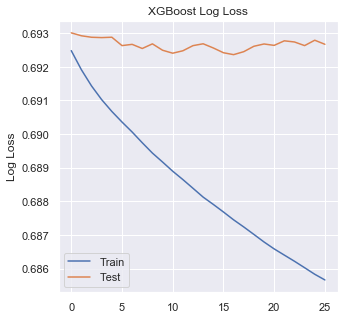

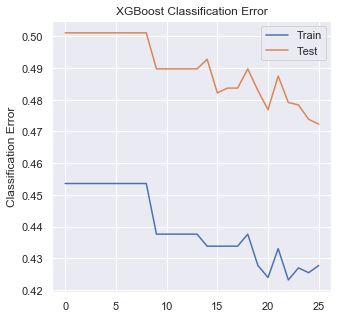

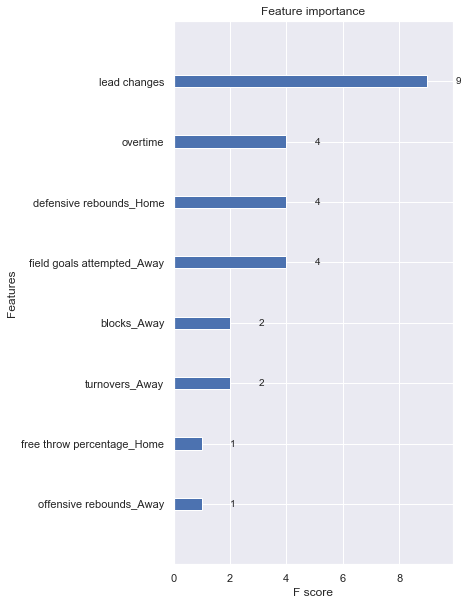

In [767]:
model = xgb.XGBClassifier(seed=968, eta=.1, n_estimators=10000, min_child_weight=1, 
                          max_depth=1, subsample=1, cosample_bytree=1, reg_lambda=10, 
                          reg_alpha=10)
evals_result ={}
eval_s = [(X_train_2012_num, y_train_2012),(X_test_2013_num, y_test_2013)]
model.fit(X_train_2012_num, y_train_2012, eval_metric=["error", "logloss"],
          early_stopping_rounds=10, eval_set=eval_s, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test_final_num)
predictions = [round(value) for value in y_pred]

# evaluate prediction
accuracy = accuracy_score(y_test_final, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

#plot importance
fig, ax = plt.subplots(figsize = (5,10))
plot_importance(model, ax=ax)
plt.show()


In [736]:
#pipeline for gridsearch crossvalidation
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv, scoring_fit,
                       probabilities):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2,
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [745]:
#using Kaggle's Xeon cpus..
#%%time
model = xgb.XGBClassifier(seed=567)
#param_grid = {
#    'eta': [.1],
#    'n_estimators': [100],
#}
param_grid = {
    'eta': [.1],
    'n_estimators': [500],
    'min_child_weight': [1],
    'colsample_bytree': [1],
    'max_depth': [1],
    'reg_alpha': [5],
    'reg_lambda': [5],
    'subsample': [1]
    }

fitted_model, pred = algorithm_pipeline(X_train_num, X_test_num, 
                                        y_train, y_test, model, param_grid, cv=indices, 
                                        scoring_fit = 'neg_log_loss', probabilities = False)

#Scores and parameters
print(round(fitted_model.best_score_, 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   52.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   52.6s finished


-0.704
{'colsample_bytree': 1, 'eta': 0.1, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 5, 'reg_lambda': 5, 'subsample': 1}


In [746]:
pred_final = fitted_model.predict(X_test_final_num)
prob_final = fitted_model.predict_proba(X_test_final_num)

In [747]:
predictions = [round(value) for value in pred_final]

# evaluate prediction
accuracy = accuracy_score(y_test_final, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 56.83%


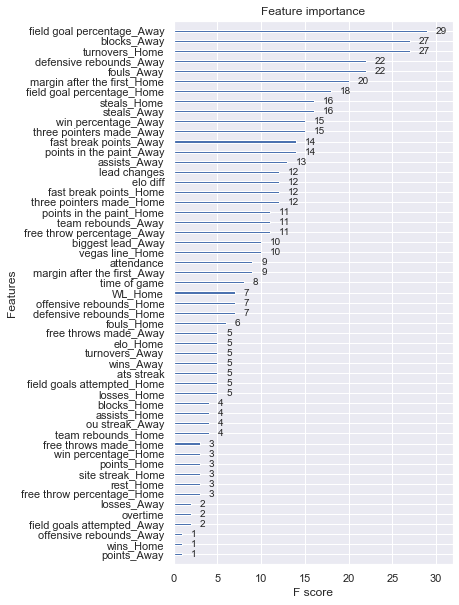

In [748]:
#plot importance
fig, ax = plt.subplots(figsize = (5,10))
plot_importance(fitted_model.best_estimator_, ax=ax)
plt.show()

In [749]:
#PROFIT based on binary choice-Start with $1000, juice is 10%, $100 min
pred_df = pd.DataFrame(predictions, columns=['prediction'])
pred_df['actual'] = y_test_final.reset_index(drop=True)
pred_df['wallet'] = 0
pred_df = pred_df[::2].reset_index(drop=True)
pred_df.head()

,prediction,actual,wallet
0,0,0,0
1,0,0,0
2,1,1,0
3,0,1,0
4,0,0,0


In [750]:
wallet = 500
for i in range(0, pred_df.shape[0]):
    if i == 0:
        if pred_df.iloc[0, pred_df.columns.get_loc('prediction')] == pred_df.iloc[0, 
            pred_df.columns.get_loc('actual')]:
            pred_df.iloc[0, pred_df.columns.get_loc('wallet')] = wallet + 90
        else:
            pred_df.iloc[0, pred_df.columns.get_loc('wallet')] = wallet - 110
    if i > 0:
        if pred_df.iloc[i, pred_df.columns.get_loc('prediction')] == pred_df.iloc[i, 
            pred_df.columns.get_loc('actual')]:
            pred_df.iloc[i, pred_df.columns.get_loc('wallet')] = pred_df.iloc[i-1, 
                pred_df.columns.get_loc('wallet')] + 90
        else:
            pred_df.iloc[i, pred_df.columns.get_loc('wallet')] = pred_df.iloc[i-1, 
                pred_df.columns.get_loc('wallet')] - 110
pred_df.head()

,prediction,actual,wallet
0,0,0,590
1,0,0,680
2,1,1,770
3,0,1,660
4,0,0,750


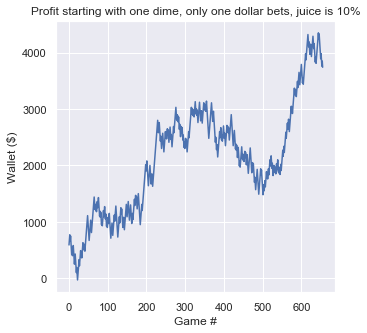

In [751]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(pred_df.index, pred_df['wallet'])
plt.xlabel('Game #')
plt.ylabel('Wallet ($)')
plt.title('Profit starting with one dime, only one dollar bets, juice is 10%')
plt.show()

In [752]:
#PROFIT based on probabilities- Start with $1000, juice is 10%, $100 min
prob_df = pd.DataFrame(prob_final, columns=['0', '1'])
prob_df['actual'] = y_test_final.reset_index(drop=True)
prob_df['wallet'] = 0
prob_df = prob_df[::2].reset_index(drop=True)
prob_df.head()

,0,1,actual,wallet
0,0.558065,0.441935,0,0
1,0.551610,0.448391,0,0
2,0.412921,0.587079,1,0
3,0.520619,0.479381,1,0
4,0.545319,0.454681,0,0


In [753]:
prob_thresh = .55
prob_df['prediction'] = -1
for i in range(0, prob_df.shape[0]):
    if prob_df.iloc[i, prob_df.columns.get_loc('0')] > prob_thresh:
        prob_df.iloc[i, prob_df.columns.get_loc('prediction')] = 0
    if prob_df.iloc[i, prob_df.columns.get_loc('1')] > prob_thresh:
        prob_df.iloc[i, prob_df.columns.get_loc('prediction')] = 1
        
prob_df.head(20)

,0,1,actual,wallet,prediction
0,0.558065,0.441935,0,0,0
1,0.551610,0.448391,0,0,0
2,0.412921,0.587079,1,0,1
3,0.520619,0.479381,1,0,-1
4,0.545319,0.454681,0,0,-1
5,0.482948,0.517052,0,0,-1
6,0.514715,0.485285,1,0,-1
7,0.489729,0.510271,0,0,-1
8,0.583517,0.416483,0,0,0
9,0.540078,0.459922,1,0,-1


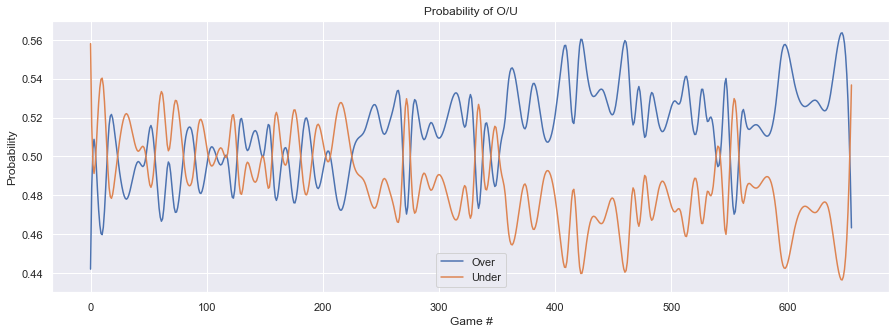

0.48862626665643566
0.5149062377796333


In [763]:
from scipy.interpolate import UnivariateSpline
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(prob_df.index.min(), prob_df.index.max(), prob_df.shape[0])  
spl0 = UnivariateSpline(prob_df.index, prob_df['0'])
spl1 = UnivariateSpline(prob_df.index, prob_df['1'])
spl0.set_smoothing_factor(.85)
spl1.set_smoothing_factor(.85)


fig, ax = plt.subplots(figsize=(15,5))
#ax.plot(prob_df.index, prob_df['0'])
ax.plot(prob_df.index, spl1(xnew), label = 'Over')
ax.plot(prob_df.index, spl0(xnew), label= 'Under')
#ax.plot(prob_df.index, prob_df['1'])
plt.xlabel('Game #')
plt.ylabel('Probability')
plt.legend()
plt.title('Probability of O/U')
plt.show()

#RMS
print(np.sqrt(np.mean(prob_df['0']**2)))
print(np.sqrt(np.mean(prob_df['1']**2)))

In [764]:
wallet = 500
for i in range(0, prob_df.shape[0]):
    if i == 0:
        if prob_df.iloc[0, prob_df.columns.get_loc('prediction')] == -1:
            prob_df.iloc[0, prob_df.columns.get_loc('wallet')] = wallet
            continue
        if prob_df.iloc[0, prob_df.columns.get_loc('prediction')] == prob_df.iloc[0, 
            prob_df.columns.get_loc('actual')]:
            prob_df.iloc[0, prob_df.columns.get_loc('wallet')] = wallet + 90
        else:
            prob_df.iloc[0, prob_df.columns.get_loc('wallet')] = wallet - 110
    if i > 0:
        if prob_df.iloc[i, prob_df.columns.get_loc('prediction')] == -1:
            prob_df.iloc[i, prob_df.columns.get_loc('wallet')] = prob_df.iloc[i-1, prob_df.columns.get_loc('wallet')]
            continue
        if prob_df.iloc[i, prob_df.columns.get_loc('prediction')] == prob_df.iloc[i, 
            prob_df.columns.get_loc('actual')]:
            prob_df.iloc[i, prob_df.columns.get_loc('wallet')] = prob_df.iloc[i-1, 
                prob_df.columns.get_loc('wallet')] + 90
        else:
            prob_df.iloc[i, prob_df.columns.get_loc('wallet')] = prob_df.iloc[i-1, 
                prob_df.columns.get_loc('wallet')] - 110
prob_df.head()

,0,1,actual,wallet,prediction
0,0.558065,0.441935,0,590,0
1,0.551610,0.448391,0,680,0
2,0.412921,0.587079,1,770,1
3,0.520619,0.479381,1,770,-1
4,0.545319,0.454681,0,770,-1


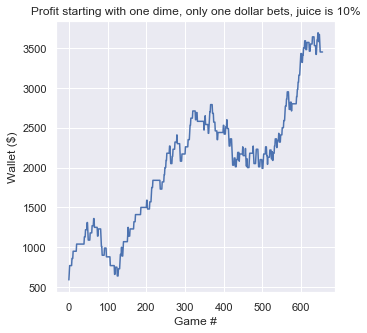

In [765]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(prob_df.index, prob_df['wallet'])
plt.xlabel('Game #')
plt.ylabel('Wallet ($)')
plt.title('Profit starting with one dime, only one dollar bets, juice is 10%')
plt.show()

In [168]:
model = xgb.XGBRegressor(seed=294)
param_grid = {
    'eta': [.05],
    'n_estimators': [800],
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled, 
                                        X_test_scaled, y_train_cont, y_test_cont, model, 
                                        param_grid, cv=indices, scoring_fit = 'neg_mean_squared_error', 
                                        probabilities = False)

#Scores and parameters
print(round(np.sqrt(-fitted_model.best_score_), 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   48.2s finished


18.509
{'eta': 0.05, 'n_estimators': 800}


In [169]:
y_test_cont.std()

17.37152451356122

In [ ]:
pred_final = fitted_model.predict(X_test_final_num[ext_game_mask])


In [ ]:
print(pred_final)

In [ ]:
y_test_cont_final

In [53]:
%%time
model = LGBMClassifier(seed=132)
param_grid = {
    'eta': [.05],
    'n_estimators': [800],
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled[ext_game_mask], X_test_scaled[ext_game_mask], y_train, 
                                        y_test, model, 
                                 param_grid, cv=indices, scoring_fit = 'accuracy', 
                                 probabilities = False)

#Scores and parameters
print(round(fitted_model.best_score_, 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s finished


0.508
{'eta': 0.05, 'n_estimators': 800}
Wall time: 14.8 s


In [171]:
model = LogisticRegression(random_state=72)
param_grid = {
    'max_iter': [1000],
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled, X_test_scaled, y_train, 
                                        y_test, model, 
                                 param_grid, cv=indices, scoring_fit = 'neg_mean_squared_error', 
                                 probabilities = False)

#Scores and parameters
print(round(np.sqrt(-fitted_model.best_score_), 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.3s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [55]:
y_test.std()

0.499967145651772

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test_2017_scaled[ext_game_mask])
predictions = [round(value) for value in y_pred]

# evaluate prediction
accuracy = accuracy_score(y_test_final, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

probas_train = model.predict_proba(X_train_2016_scaled[ext_game_mask])
log_loss_train = log_loss(y_train_2016, probas_train)
print(log_loss_train)

probas_test = model.predict_proba(X_test_2017_scaled[ext_game_mask])
log_loss_test = log_loss(y_test_2017, probas_test)
print(log_loss_test)

In [56]:
model = SVC(random_state=893, kernel = 'rbf')
param_grid = {
    'degree': [3],
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled[ext_game_mask], X_test_scaled[ext_game_mask], y_train, 
                                        y_test, model, 
                                 param_grid, cv=indices, scoring_fit = 'accuracy', 
                                 probabilities = False)

#Scores and parameters
print(round(fitted_model.best_score_, 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished


0.506
{'degree': 3}


In [57]:
model = RandomForestClassifier(random_state=734)
param_grid = {
    'max_depth': [2],
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled[ext_game_mask], X_test_scaled[ext_game_mask], y_train, 
                                        y_test, model, 
                                 param_grid, cv=indices, scoring_fit = 'accuracy', 
                                 probabilities = False)

#Scores and parameters
print(round(fitted_model.best_score_, 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.8s finished
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.505
{'max_depth': 2}


In [58]:
model = GaussianNB()
param_grid = {
    'var_smoothing': [10**-9],
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled[ext_game_mask], X_test_scaled[ext_game_mask], y_train, 
                                        y_test, model, 
                                 param_grid, cv=indices, scoring_fit = 'accuracy', 
                                 probabilities = False)

#Scores and parameters
print(round(fitted_model.best_score_, 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.502
{'var_smoothing': 1e-09}


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


In [59]:
pred_final = fitted_model.predict(X_test_final_scaled[ext_game_mask])
predictions = [round(value) for value in pred_final]

# evaluate prediction
accuracy = accuracy_score(y_test_final, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 52.78%


In [60]:
model = KNeighborsClassifier()
param_grid = {
    #'n_neighbors': np.array(range(25,40)),
    'n_neighbors': [35],
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled[ext_game_mask], X_test_scaled[ext_game_mask], y_train, 
                                        y_test, model, 
                                 param_grid, cv=indices, scoring_fit = 'accuracy', 
                                 probabilities = False)

#Scores and parameters
print(round(fitted_model.best_score_, 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished


0.494
{'n_neighbors': 35}


In [66]:
model = LinearRegression()
param_grid = {
    'fit_intercept': [False]
    #'n_neighbors': np.array(range(25,40)),
    #'estimator': ['ridge', 'lasso'],
    #'alpha': [.01, .001, .1]
}
#param_grid = {
#    'eta': [.005, .01, .05, .1],
#    'n_estimators': [100, 200, 400, 800, 1600],
#    'min_child_weight': [.8, 1, 1.2],
#    'colsample_bytree': [.8, 1, 1.2],
#    'max_depth': [3,4,5, 6, 7, 8, 9, 10, 15],
#    'reg_alpha': [.6, .8, .9, 1, 1.1],
#    'reg_lambda': [.6, .8, .9, 1, 1.1],
#    'subsample': [.6, 0.8, 1]
#}

fitted_model, pred = algorithm_pipeline(X_train_scaled[ext_game_mask], X_test_scaled[ext_game_mask], y_train_cont, 
                                        y_test_cont, model, 
                                 param_grid, cv=indices, scoring_fit = 'neg_mean_squared_error', 
                                 probabilities = False)

#Scores and parameters
print(round(np.sqrt(-fitted_model.best_score_), 3))
print(fitted_model.best_params_)
fits = pd.DataFrame(fitted_model.cv_results_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.0s finished


17.462
{'fit_intercept': False}


In [27]:
cat_feat_ind = (X_train_2016[ext_game_mask].dtypes == 'object').nonzero()[0]
pool_train = Pool(X_train_2016[ext_game_mask], y_train_2016, cat_features=cat_feat_ind)
pool_val = Pool(X_test_2017[ext_game_mask], y_test_2017, cat_features=cat_feat_ind)
pool_test = Pool(X_test_final[ext_game_mask], y_test_final, cat_features=cat_feat_ind)

n = y_train_2016.value_counts()
model = CatBoostClassifier(learning_rate=.001,
                           iterations=500,
                           depth=3,
                           l2_leaf_reg=10,
                           random_strength=5,
                           #bagging_temperature=1,
                           #grow_policy='Lossguide',
                           #min_data_in_leaf=1,
                           #max_leaves=1,
                           early_stopping_rounds=100,
                           class_weights=[1, n[0] / n[1]],
                           verbose=False,
                           random_state=534)
model.fit(pool_train, eval_set=pool_val, plot=True);

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  """Entry point for launching an IPython kernel.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy (test): 0.530
Precision (test): 0.524
Recall (test): 0.876


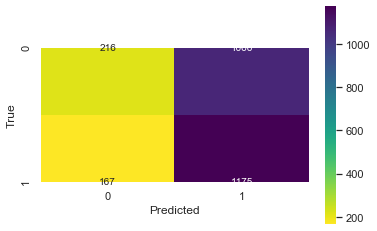

In [28]:
y_pred_test = model.predict(pool_test)

acc_test = accuracy_score(y_test_final, y_pred_test)
prec_test = precision_score(y_test_final, y_pred_test)
rec_test = recall_score(y_test_final, y_pred_test)
print(f'''Accuracy (test): {acc_test:.3f}
Precision (test): {prec_test:.3f}
Recall (test): {rec_test:.3f}''')

cm = confusion_matrix(y_test_final, y_pred_test)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

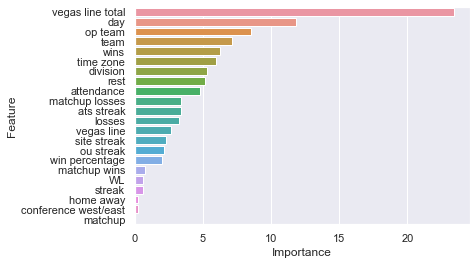

In [238]:
feat = model.feature_names_
imp = model.feature_importances_
df = pd.DataFrame({'Feature': feat, 'Importance': imp})
df = df.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=df);